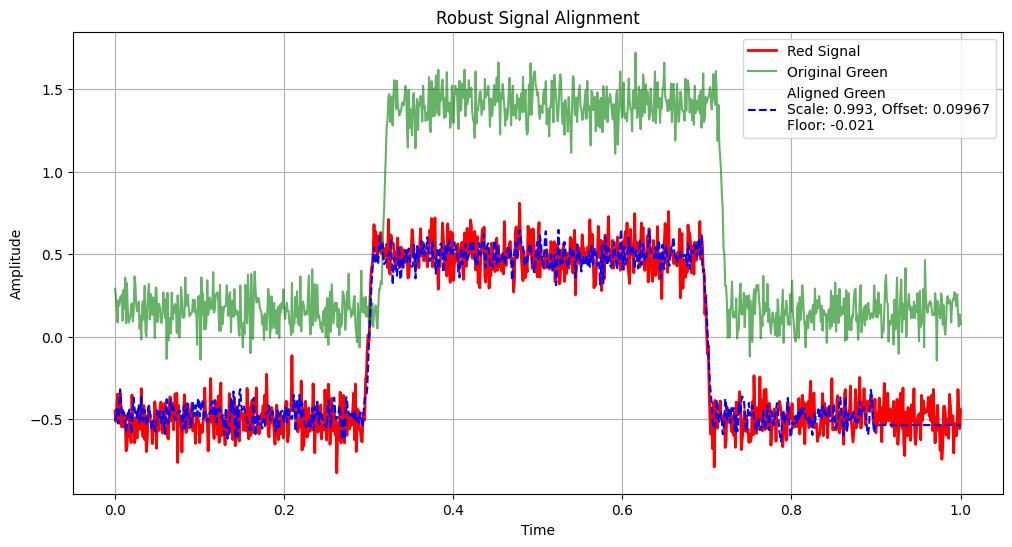

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, correlate
from scipy.optimize import minimize
from scipy.ndimage import shift

def generate_signals():
    np.random.seed(42)
    t = np.linspace(0, 1, 1000)
    red_floor = -0.5
    pulse = np.heaviside(t - 0.3, 1) - np.heaviside(t - 0.7, 1)
    red_signal = savgol_filter(pulse, 21, 2) + 0.1 * np.random.randn(*t.shape) + red_floor
    
    # Create green signal
    scale = 1.25
    offset = 0.018
    green_floor = 0.15
    green_pulse = scale * (np.heaviside(t - (0.3 + offset), 1) - np.heaviside(t - (0.7 + offset), 1))
    green_signal = savgol_filter(green_pulse, 21, 2) + 0.1 * np.random.randn(*t.shape) + green_floor
    
    return t, red_signal, green_signal

def robust_edge_detector(signal, t, min_prominence=0.2):
    """Edge detection with numerical stability fixes"""
    dt = t[1] - t[0]
    signal = signal.copy() + 1e-12 * np.random.randn(*signal.shape)
    
    try:
        deriv = savgol_filter(
            np.gradient(signal, dt),
            window_length=21,
            polyorder=2,
            mode='nearest'
        )
    except np.linalg.LinAlgError:
        deriv = np.gradient(signal, dt)
    
    rising_peaks, _ = find_peaks(deriv, prominence=min_prominence)
    falling_peaks, _ = find_peaks(-deriv, prominence=min_prominence)
    
    all_edges = np.sort(np.concatenate((rising_peaks, falling_peaks)))
    return t[all_edges[:2]] if len(all_edges) >= 2 else np.array([])

def floor_shift_optimization(t, red_signal, green_signal):
    """Step 1: Floor shift optimization"""
    red_edges = robust_edge_detector(red_signal, t)
    baseline_mask = (t < 0.1) | (t > 0.9) if len(red_edges) < 2 else (
        (t < red_edges[0] - 0.05) | (t > red_edges[-1] + 0.05)
    )
    
    def floor_cost(floor):
        return np.median(np.abs((green_signal + floor - red_signal)[baseline_mask]))
    
    floor_result = minimize(floor_cost, 0.0, method='Powell', 
                           options={'xtol': 1e-6, 'ftol': 1e-6})
    green_floor_adj = green_signal + floor_result.x[0]
    
    return green_floor_adj, floor_result.x[0]

def scaling_optimization(t, red_signal, green_floor_adj):
    """Step 2: Scaling optimization"""
    def scale_cost(scale):
        scaled_green = scale * green_floor_adj
        return np.mean((scaled_green - red_signal)**2)
    
    scale_result = minimize(scale_cost, 1.0, method='L-BFGS-B', 
                           bounds=[(0.5, 2.0)], 
                           options={'maxiter': 1000, 'ftol': 1e-9})
    green_scaled_adj = scale_result.x[0] * green_floor_adj
    
    return green_scaled_adj, scale_result.x[0]

def offset_tuning_optimization(t, red_signal, green_scaled_adj):
    """Step 3: Offset tuning optimization"""
    red_edges = robust_edge_detector(red_signal, t)
    green_edges = robust_edge_detector(green_scaled_adj, t)
    
    if len(red_edges) >= 2 and len(green_edges) >= 2:
        edge_mask = (t >= red_edges[0] - 0.05) & (t <= red_edges[-1] + 0.05)
    else:
        edge_mask = np.ones_like(t, dtype=bool)
    
    def offset_cost(offset):
        shifted_green = shift(green_scaled_adj, -offset/(t[1]-t[0]), order=3, mode='nearest')
        return np.mean((shifted_green[edge_mask] - red_signal[edge_mask])**2)
    
    offset_result = minimize(offset_cost, 0.0, method='L-BFGS-B', 
                            bounds=[(-0.1, 0.1)], 
                            options={'maxiter': 1000, 'ftol': 1e-9})
    green_offset_adj = shift(green_scaled_adj, -offset_result.x[0]/(t[1]-t[0]), order=3, mode='nearest')
    
    return green_offset_adj, offset_result.x[0]

def integrated_optimization(t, red_signal, green_offset_adj, initial_params):
    """Step 4: Integrated optimization"""
    def integrated_cost(params):
        floor, scale, offset = params
        adjusted_green = scale * shift(green_offset_adj + floor, -offset/(t[1]-t[0]), order=3, mode='nearest')
        return np.mean((adjusted_green - red_signal)**2)
    
    result = minimize(integrated_cost, initial_params, method='L-BFGS-B', 
                      bounds=[(-1.0, 1.0), (0.5, 2.0), (-0.1, 0.1)], 
                      options={'maxiter': 1000, 'ftol': 1e-9})
    
    floor_opt, scale_opt, offset_opt = result.x
    green_integrated_adj = scale_opt * shift(green_offset_adj + floor_opt, -offset_opt/(t[1]-t[0]), order=3, mode='nearest')
    
    return green_integrated_adj, floor_opt, scale_opt, offset_opt

def align_signals(t, red_signal, green_signal):
    # Step 1: Floor shift optimization
    green_floor_adj, floor_shift = floor_shift_optimization(t, red_signal, green_signal)
    
    # Step 2: Scaling optimization
    green_scaled_adj, scale_opt = scaling_optimization(t, red_signal, green_floor_adj)
    
    # Step 3: Offset tuning optimization
    green_offset_adj, offset_opt = offset_tuning_optimization(t, red_signal, green_scaled_adj)
    
    # Step 4: Integrated optimization
    initial_params = [floor_shift, scale_opt, offset_opt]
    green_integrated_adj, floor_opt, scale_opt, offset_opt = integrated_optimization(t, red_signal, green_offset_adj, initial_params)
    
    return scale_opt, offset_opt, floor_opt, green_integrated_adj

def iterative_alignment(t, red_signal, green_signal, max_iter=3):
    for _ in range(max_iter):
        floor, scale, offset, green_signal = align_signals(t, red_signal, green_signal)
    return floor, scale, offset, green_signal

# Plotting code remains the same
t, red, green = generate_signals()
scale, offset, floor, adj_green = iterative_alignment(t, red, green)

plt.figure(figsize=(12, 6))
plt.plot(t, red, 'r', label='Red Signal', lw=2)
plt.plot(t, green, 'g', alpha=0.6, label='Original Green')
plt.plot(t, adj_green, 'b--', lw=1.5, 
         label=f'Aligned Green\nScale: {scale:.3f}, Offset: {offset:.5f}\nFloor: {floor:.3f}')
plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.title('Robust Signal Alignment'), plt.legend(), plt.grid(True)
plt.show()